In [ ]:
#auto reload modules
%load_ext autoreload
%autoreload 2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision
import torch
from data_train import ObjectDetectionDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Create image labels

In [ ]:
train_image_dir = '../datasets/centered_cells/whole_set/'
# load one image
img = plt.imread(train_image_dir + 'BA_3107.jpg')
train_image_height = img.shape[0]
train_image_width = img.shape[1]

In [ ]:
train_img_end_width = 640
train_img_end_height = 480
train_img_height_ratio = train_img_end_height / train_image_height
train_img_width_ratio = train_img_end_width / train_image_width



annotation_path = "../image_stitching/labels.csv"
image_dir = '../image_stitching/'
idx2name = {
    0: 'LY',
    1: 'RBC',
    2: 'PLT',
    3: 'EO',
    4: 'MO',
    5: 'BNE',
    6: 'SEN',
    7: 'BA',
    8: 'PAD',
            }

name2idx = {v:k for k, v in idx2name.items()}

In [ ]:
# so I'm resizing the images to the ratio of resizing the training images because I think the model thinks the images are too small

In [ ]:
import pandas as pd
import cv2
path = '/Users/liam/Documents/deMello_semProject/image_stitching/'
df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'width', 'height', 'class', 'filename'])
img_width_ratio = 640/360
img_height_ratio = 480/360
for i in range(1, 4):
    path_to_label = path + 'stich_' + str(i) + '.txt'

    path_to_img = path + 'stich_' + str(i) + '.png'

    img = cv2.imread(path_to_img)
    img_size = img.shape[:2]
    width = img_size[1]
    height = img_size[0]

    filename = path_to_img.split('/')[-1]


    with open(path_to_label) as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(' ')
            cls = idx2name[int(line[0])]
            xcenter = int(float(line[1]) * width)
            ycenter = int(float(line[2]) * height)
            bbox_w = int(float(line[3]) * width)
            bbox_h = int(float(line[4]) * height)
            xmin = xcenter - bbox_w // 2
            ymin = ycenter - bbox_h // 2
            xmax = xcenter + bbox_w // 2
            ymax = ycenter + bbox_h // 2
            df = df.append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax, 'width': width, 'height': height, 'class': cls, 'filename': filename}, ignore_index=True)
df.to_csv('../image_stitching/labels.csv')


In [100]:
from yolov5.utils.metrics import bbox_iou
import os

# balance yolo dataset
source_ds_path = '../datasets/centered_cells/labels_imbalanced/'
target_ds_path = '../datasets/centered_cells/labels/'
folders = ['train/', 'test/', 'val/']
df = pd.read_csv('../Detecto/labels_balanced.csv')
print(df.columns)
# for file in df['filename'].unique():
#     df_file = df[df['filename'] == file]
#     # remove .jpg add. txt
#     label_file = file[:-4] + '.txt'
#
#     #check in which of the folders the file is
#     for folder in folders:
#         if label_file in os.listdir(source_ds_path + folder):
#             src_path = source_ds_path + folder
#             final_path = target_ds_path + folder
#             print('found file in folder: ', folder)
#
#     # iterate over RBCs
#     for df_file_idx, row in df_file.iterrows():
#         # get class
#         cls = row['class']
#         # get bbox
#         xmin = row['xmin']
#         ymin = row['ymin']
#         xmax = row['xmax']
#         ymax = row['ymax']
#         # get width and height
#         width = row['width']
#         height = row['height']
#         # get center
#         xcenter = (xmin + xmax) / 2
#         ycenter = (ymin + ymax) / 2
#         # get bbox width and height
#         bbox_w = xmax - xmin
#         bbox_h = ymax - ymin
#         # get relative values
#         xcenter_rel = xcenter / width
#         ycenter_rel = ycenter / height
#         bbox_w_rel = bbox_w / width
#         bbox_h_rel = bbox_h / height
#         # create string
#         strng = str(cls_idx) + ' ' + str(xcenter_rel) + ' ' + str(ycenter_rel) + ' ' + str(bbox_w_rel) + ' ' + str(bbox_h_rel)
#
#         def line_condition(line, cls, width, height):
#             # either the class is the same and bbox iou is > 0.8, or the class is different
#             line = line.split(' ')
#             if (int(line[0]) == name2idx[cls]) and (cls == 'RBC'):
#                 # check if iou is > 0.8
#                 cx = float(line[1]) * width
#                 cy = float(line[2]) * height
#                 bw = float(line[3]) * width
#                 bh = float(line[4]) * height
#                 xmin_read = cx - bw // 2
#                 ymin_read = cy - bh // 2
#                 xmax_read = cx + bw // 2
#                 ymax_read = cy + bh // 2
#                 torch_bbox = torch.tensor([xmin, ymin, xmax, ymax])
#                 read_bbox = torch.tensor([xmin_read, ymin_read, xmax_read, ymax_read])
#                 iou = bbox_iou(torch_bbox, read_bbox)
#                 if iou > 0.8:
#                     return True
#                 else:
#                     return False
#             else:
#                 return True
#
#         # in file, delete every line that has same class but different bbox
#         with open(src_path + label_file, 'r') as f:
#             lines = f.readlines()
#         with open(final_path + label_file, 'w') as f:
#             for line in lines:
#                 if line_condition(line, cls, width, height):
#                     f.write(line)
#                 else:
#                     print('removed line: ', line)
#check in which of the folders the file is
exceptions = 0
for folder in folders:
    for label_file in os.listdir(source_ds_path + folder):
        print(label_file)
        #check if line ends with .txt
        if not label_file.endswith('.txt'):
            continue
        src_path = source_ds_path + folder
        final_path = target_ds_path + folder
        found_rbc = True
        found_plt = False
        with open(src_path + label_file, 'r') as f:
            lines = f.readlines()
        with open(final_path + label_file, 'w') as f:
            print('writing file: ', final_path + label_file)
            print(len(lines))
            for line in lines:
                if int(line.split(' ')[0]) == name2idx['RBC'] and not found_rbc:
                    print(f'writing class {name2idx["RBC"]}')
                    f.write(line)
                    found_rbc = True
                elif int(line.split(' ')[0]) == name2idx['PLT'] and not found_plt:
                    print(f'writing class {name2idx["PLT"]}')
                    f.write(line)
                    found_plt = True
                elif int(line.split(' ')[0]) != name2idx['RBC'] and line.split(' ')[0] != name2idx['PLT']:
                    f.write(line)
                else:
                    print('removed line: ', line)
#print amount of each class in df
print(df['class'].value_counts())
print('exceptions: ', exceptions)

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax',
       'image_id'],
      dtype='object')
MO_362689.txt
writing file:  ../datasets/centered_cells/labels/train/MO_362689.txt
16
removed line:  1 0.5444444444444444 0.14444444444444443 0.2361111111111111 0.16666666666666666 

removed line:  1 0.8444444444444444 0.32222222222222224 0.19444444444444445 0.18888888888888888 

removed line:  1 0.9472222222222222 0.06944444444444445 0.10277777777777777 0.14166666666666666 

removed line:  1 0.2833333333333333 0.04722222222222222 0.18055555555555555 0.09444444444444444 

removed line:  1 0.09444444444444444 0.08333333333333333 0.175 0.1638888888888889 

removed line:  1 0.1111111111111111 0.5305555555555556 0.2111111111111111 0.2222222222222222 

removed line:  1 0.23055555555555557 0.4777777777777778 0.14722222222222223 0.2638888888888889 

removed line:  1 0.2833333333333333 0.2777777777777778 0.21944444444444444 0.18055555555555555 

removed line:  1 0.0694444444

In [ ]:
from torchvision.models.detection.backbone_utils import _validate_trainable_layers

weights_backbone = torch.load('../torch_rcnn_try/runs/run11_resnet_bboxes160epoch/small_model_run_resnet_80.pt', map_location=torch.device('cpu'))
weights = torch.load('../torch_rcnn_try/runs/run6/model_run4_balance_v2_80.pt', map_location=torch.device('cpu'))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2()
#load weights
model.load_state_dict(weights)
# model.backbone.load_state_dict(weights_backbone)
resnet = torchvision.models.resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, len(idx2name.keys()))
resnet.load_state_dict(weights_backbone)
backbone = torchvision.models.detection.backbone_utils._resnet_fpn_extractor(resnet, _validate_trainable_layers(True, None, 5, 3))


In [ ]:
model.backbone.load_state_dict(weights_backbone)

In [ ]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height_ratio, img_width_ratio), name2idx, pad=False)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
od_dataloader = DataLoader(od_dataset, collate_fn=collate_fn, batch_size=2)

In [ ]:
# load
model.eval()
for img_batch, targets_batch in od_dataloader:
    img_data_all = img_batch
    targets_batch_all = targets_batch
    prediction_batch = model(img_data_all)
    print(type(prediction_batch[0]))

In [ ]:
model.eval()
accuracy = 0
for img_batch, targets_batch in od_dataloader:
    img_data_all = img_batch
    targets_batch_all = targets_batch
    prediction_batch = model(img_data_all)
    # cut out each box out of image and put it into resnet
    for img, targets, predictions in zip(img_data_all, targets_batch_all, prediction_batch):
        img = img.permute(1, 2, 0).numpy()
        picture_acc = 0
        for idx, box in enumerate(targets['boxes']):
            xmin, ymin, xmax, ymax = box.detach().numpy()
            img_cropped = img[int(ymin):int(ymax), int(xmin):int(xmax), :]
            if img_cropped.shape[0] == 0 or img_cropped.shape[1] == 0:
                continue
            img_cropped = cv2.resize(img_cropped, (224, 224))
            img_cropped = torch.from_numpy(img_cropped).permute(2, 0, 1).unsqueeze(0)
            prediction = resnet(img_cropped)
            prediction = prediction.argmax().item()
            if prediction == targets['labels'][idx].item():
                picture_acc += 1
            # print(prediction)
            # print(idx2name[targets['labels'][idx].item()])
            # print(idx2name[prediction.argmax().item()])
            # print('------------------')
        accuracy += picture_acc / len(targets['boxes'])
        print(picture_acc / len(targets['boxes']))
        print('------------------')
print(accuracy / len(od_dataset))

In [ ]:
model.eval()
for img_batch, targets_batch in od_dataloader:
    img_data_all = img_batch
    targets_batch_all = targets_batch
    prediction_batch = model(img_data_all)
    # plot each image with target boxes and predicted boxes using matplotlib (plt)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for img, targets, predictions in zip(img_data_all, targets_batch_all, prediction_batch):
        img = img.permute(1, 2, 0).numpy()
        ax1.imshow(img)
        ax2.imshow(img)
        for idx, box in enumerate(targets['boxes']):
            if idx2name[targets['labels'][idx].item()] == 'RBC':
                continue
            xmin, ymin, xmax, ymax = box.detach().numpy()
            ax1.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r'))
            # add class name
            ax1.text(xmin, ymin, idx2name[targets['labels'][idx].item()], bbox=dict(facecolor='white', alpha=0.5))
        for idx, box in enumerate(predictions['boxes']):
            if idx2name[predictions['labels'][idx].item()] == 'RBC':
                continue
            xmin, ymin, xmax, ymax = box.detach().numpy()
            ax2.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r'))
            # add class name
            ax2.text(xmin, ymin, idx2name[predictions['labels'][idx].item()], bbox=dict(facecolor='white', alpha=0.5))
        plt.show()

In [ ]:
model.eval()

## Splitting images and boxes

In [ ]:
#define plot_image function
def plot_image(img, boxes, labels, scores, title=None):
    # define colors
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    # plot the image
    plt.figure(figsize=(10,10))
    plt.imshow(img.permute(1, 2, 0).cpu())
    current_axis = plt.gca()
    # plot the ground truth boxes
    for box, label, score in zip(boxes, labels, scores):
        if idx2name[label.item()] == 'RBC' or idx2name[label.item()] == 'PLT':
            continue
        xmin, ymin, xmax, ymax = box
        color = colors[label]
        label = f'{idx2name[label.item()]}: {score.item():.2f}'
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [ ]:
# Load the saved file
model = torch.hub.load('../yolov5', 'custom', path='../yolov5/runs/train/exp11/weights/best.pt', source='local')  # local model


In [ ]:
from app.image_splitting import split_inference_reconstruct

# load
model.eval()
for img_batch, targets_batch in od_dataloader:
    img_data_all = img_batch
    targets_batch_all = targets_batch
    # prediction_batch = split_inference_reconstruct(model, img_data_all, split_size=720)
    # img_data_all = [img.permute(1, 2, 0).numpy() for img in img_data_all]
    prediction_batch = model(img_data_all)
    prediction_batch.show()
    break

In [ ]:
# plot first image twice, once with ground truth boxes and once with predicted boxes
img = img_data_all[0]
boxes = targets_batch_all[0]['boxes']
labels = targets_batch_all[0]['labels']
scores = torch.ones(len(boxes))
plot_image(img, boxes, labels, scores, title='Ground Truth')
boxes = prediction_batch[0]['boxes']
labels = prediction_batch[0]['labels']
scores = prediction_batch[0]['scores']
plot_image(img, boxes, labels, scores, title='Predictions')


In [ ]:
# create function that takes batch, splits it into smaller images, runs inference on each image, and reconstructs the boxes for each image into a single batch
def split_inference(model, img_batch, split_size=720, iou_threshold=0.5):
    # split the first image in the batch
    split_images, split_boxes, split_labels = split_image_and_boxes(img_batch[0], targets_batch_all[0], split_size=split_size)
    # run inference on each split
    split_outputs = []
    for img, boxes, labels in zip(split_images, split_boxes, split_labels):
        img = img.unsqueeze(0)
        output = model(img)
        split_outputs.append(output)
    # reconstruct the boxes
    split_boxes = [output['boxes'][0] for output in split_outputs]
    split_labels = [output['labels'][0] for output in split_outputs]
    split_scores = [output['scores'][0] for output in split_outputs]
    boxes, labels, scores = reconstruct_boxes(split_boxes, split_labels, split_scores, split_size=split_size, img_size=img_batch.shape[-2:], iou_threshold=iou_threshold)
    return boxes, labels, scores

In [ ]:
from app.image_splitting import split_image_and_boxes, reconstruct_boxes
for img_batch, targets_batch in od_dataloader:
    img_data_all = img_batch
    targets_batch_all = targets_batch
    # split the first image in the batch
    split_images, split_boxes, split_labels = split_image_and_boxes(img_data_all[0], targets_batch_all[0])
    # plot the first 10 images with target boxes and predicted boxes using matplotlib (plt)
    fig, axes = plt.subplots(1, 10)
    i = 0
    for img, targets, labels, ax in zip(split_images, split_boxes, split_labels, axes):
        if i == 10:
            break
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        for idx, box in enumerate(targets):
            xmin, ymin, xmax, ymax = box.detach().numpy()
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r'))
            # add class name
            ax.text(xmin, ymin, idx2name[labels[idx].item()], bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

    print(split_boxes)

    #now just plot the very first split image with target boxes
    fig, ax = plt.subplots(1, 1)
    img = split_images[1].permute(1, 2, 0).numpy()
    ax.imshow(img)
    for idx, box in enumerate(split_boxes[1]):
        print('box', box)
        xmin, ymin, xmax, ymax = box.detach().numpy()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r'))
        # add class name
        ax.text(xmin, ymin, idx2name[split_labels[1][idx].item()], bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


    break


In [ ]:
# now let's try to reconstruct the boxes
all_boxes, all_labels = reconstruct_boxes(split_boxes, split_labels, img_size=img_data_all[0].shape[-2:])
# plot
fig, ax = plt.subplots(1, 1)
img = img_data_all[0].permute(1, 2, 0).numpy()
ax.imshow(img)
for idx, box in enumerate(all_boxes):
    xmin, ymin, xmax, ymax = box.detach().numpy()
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='r'))
    # add class name
    ax.text(xmin, ymin, idx2name[all_labels[idx].item()], bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# So the problem I have right now is that the model always sees PLTS, and doesn't really classify correctly. So I need to figure out how to split the images and boxes correctly.

In [ ]:
def cut_patches(image, targets, split_size):
    h, w = image.shape[-2:]  # assuming img is (C, H, W) or (B, C, H, W)
    boxes = targets['boxes']

    patches = []
    patch_targets = []

    for box in boxes:
        # Get the coordinates of the box (as int)
        x1, y1, x2, y2 = box.int()

        # Calculate the center of the box
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Define start and end coordinates for the patch
        start_x = max(0, center_x - split_size // 2)
        start_y = max(0, center_y - split_size // 2)
        end_x = min(w, start_x + split_size)
        end_y = min(h, start_y + split_size)

        # Correct start_x and start_y if the patch would go beyond the image borders
        if end_x - start_x < split_size:
            start_x = end_x - split_size
        if end_y - start_y < split_size:
            start_y = end_y - split_size

        # Extract patch
        patch = image[:, start_y:end_y, start_x:end_x]

        # Extract boxes within this patch
        patch_boxes_indices = ((boxes[:, 0] >= start_x) & (boxes[:, 2] < end_x) &
                               (boxes[:, 1] >= start_y) & (boxes[:, 3] < end_y))

        patch_boxes = boxes[patch_boxes_indices].clone()

        # Adjust box coordinates relative to the patch
        patch_boxes[:, [0, 2]] -= start_x
        patch_boxes[:, [1, 3]] -= start_y

        # Store patch and patch targets
        patches.append(patch)
        patch_targets.append({
            'boxes': patch_boxes,
            'labels': targets['labels'][patch_boxes_indices],
        })

    return patches, patch_targets


In [ ]:
import torchvision.ops.boxes as box_ops
def clip_boxes(boxes):
    """
    Clip boxes to lie entirely within the image
    boxes: (N, 4)
    """
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(min=0, max=1)
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(min=0, max=1)
    # Remove boxes with zero area (those lying on the borders)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    return boxes[areas.squeeze() > 0]


def calculate_accuracy(predictions, targets):
    total_boxes = 0
    correct_boxes = 0
    total_classifications = 0
    correct_classifications = 0

    for i, prediction in enumerate(predictions):
        target = targets[i]

        if len(prediction['boxes']) == 0 or len(target['boxes']) == 0:
            continue

        # Match predicted boxes to target boxes based on IoU
        ious = box_ops.box_iou(target['boxes'], prediction['boxes'])
        max_ious, max_iou_indices = ious.max(dim=1)

        # Only consider boxes with IoU > 0.5 as matched
        matched_indices = max_iou_indices[max_ious > 0.5]
        matched_target_indices = torch.arange(len(matched_indices))

        # Match labels for matched boxes
        predicted_labels = prediction['labels'][matched_indices]
        target_labels = target['labels'][matched_target_indices]

        total_boxes += len(matched_indices)
        correct_boxes += len(matched_indices)
        total_classifications += len(target_labels)
        correct_classifications += (predicted_labels == target_labels).sum().item()

    # Calculate accuracy, with a higher weight on correct classifications
    accuracy = (correct_classifications / total_classifications) if total_classifications > 0 else 0

    return accuracy


In [ ]:
from app.image_splitting import split_image_and_boxes, yolo_to_rcnn
from matplotlib import patches
from app import image_splitting
from skimage.transform import resize

train_img_end_width = 640
train_img_end_height = 480
train_img_height_ratio = 1
train_img_width_ratio = 1

def find_optimal_split_size(model, image, targets, min_split_size=360, max_split_size=720, step=120):
    best_accuracy = 0
    best_split_size = min_split_size
    model_name = 'yolo'

    for split_size in range(min_split_size, max_split_size+1, step):
        step_size = split_size // 2

        print(f'Trying split size {split_size} with step size {step_size}')

        # Split images
        split_images, split_boxes, split_labels = split_image_and_boxes(image, boxes=targets['boxes'], labels=targets['labels'], split_size=split_size, step_size=step_size)

        target_dicts = [{'boxes': boxes, 'labels': labels} for boxes, labels in zip(split_boxes, split_labels)]


        all_outputs = []
        # Run inference on the batch of splits in groups of batch_size
        batch_size = 4
        for i in range(0, len(split_images), batch_size):

            with torch.no_grad():
                if model_name == 'rcnn':
                    batch_outputs = model(tuple(split_images[i:i+batch_size]))  # Model takes a tuple of images
                elif model_name == 'yolo':
                    # split images to numpy
                    model_input = [img.permute(1, 2, 0).numpy()*255 for img in split_images[i:i+batch_size]]
                    # run inference
                    batch_outputs = model(model_input)
                    if i == 0:
                        # plot image batch
                        fig, ax = plt.subplots(1, len(model_input), figsize=(16, 8))
                        for j, img in enumerate(model_input):
                            ax[j].imshow(img.astype(np.uint8))
                            ax[j].set_title(f'Image {j}')
                        plt.show()
                        batch_outputs.show()
                    batch_outputs = yolo_to_rcnn(batch_outputs, remove_rbc=True)

            all_outputs.extend(batch_outputs)
        results = all_outputs

        amt_samples = min(len(split_images), 10)

        # plot image with targets and predictions
        fig, ax = plt.subplots(2, amt_samples, figsize=(16, 8))

        for i in range(amt_samples):
            splt_img = split_images[i]
            target_split_boxes = split_boxes[i]
            results = all_outputs[i]
            ax[0, i].imshow(splt_img.permute(1, 2, 0))
            ax[1, i].imshow(splt_img.permute(1, 2, 0))
            for box in target_split_boxes:
                box = box.int()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
                ax[0, i].add_patch(rect)
            for box in results['boxes']:
                box = box.int()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='g', facecolor='none')
                ax[1, i].add_patch(rect)
        plt.show()




        # Calculate accuracy
        accuracy = calculate_accuracy(all_outputs, target_dicts)

        # Update best split size and accuracy
        if accuracy > best_accuracy:
            best_split_size = split_size
            best_accuracy = accuracy

    return best_split_size, best_accuracy


In [ ]:
%matplotlib inline
img_data_all, targets_batch_all = od_dataset[2]
img_data_all, targets_batch_all = (img_data_all,) , (targets_batch_all,)
#show image

# darken slightly and add a bit of red
img_dark = img_data_all[0] * 1 # darken

# # Increase contrast
# # Substract mean, multiply by a factor > 1, then add mean back
# mean = img_dark.mean()
# img_contrast = (img_dark - mean) * 1.7 + mean  # 20% more contrast
#
# # Add a bit of red
# # Add a constant to the red channel
# # Clipping is necessary to ensure values are in the [0, 1] range (or [0, 255] if that's the case)
# img_red = img_contrast.clone()
# img_red[0] = torch.clamp(img_red[0] + 0.17, 0, 1)  # Add 10% red
# img_red[1] = torch.clamp(img_red[1] + 0.04, 0, 1)
#
# plt.imshow(img_red.permute(1, 2, 0))
# add boxes
for box in targets_batch_all[0]['boxes']:
    box = box.int()
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()
plt.imshow(cv2.imread('../image_stitching/stich_3.png'))

In [27]:
def make_red(img):
    # Increase contrast
    # Substract mean, multiply by a factor > 1, then add mean back
    mean = img.mean()
    img_contrast = (img - mean) * 1.2 + mean  # 20% more contrast

    # Add a bit of red
    # Add a constant to the red channel
    # Clipping is necessary to ensure values are in the [0, 1] range (or [0, 255] if that's the case)
    img_red = img_contrast.clone()
    img_red[0] = torch.clamp(img_red[0] + 0.17, 0, 1)  # Add 10% red
    img_red[1] = torch.clamp(img_red[1] + 0.04, 0, 1)
    return img_red

In [98]:
# Load the saved file
model = torch.hub.load('../yolov5', 'custom', path='../yolov5/runs/train/exp11/weights/best.pt', source='local')  # local model

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-2.1.0.dev20230526 CPU

Fusing layers... 
Model summary: 212 layers, 20881221 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [99]:
model.max_det

1000

In [ ]:
model.eval()
new_img = cv2.imread('../image_stitching/stich_3.png')
new_img = torch.from_numpy(new_img).permute(2,0,1).to(dtype=torch.float32)
best_split_size, best_accuracy = find_optimal_split_size(model, img_data_all[0], targets_batch_all[0], min_split_size=360, max_split_size=1200)
print(f'Best split size: {best_split_size}, best accuracy: {best_accuracy}')

In [ ]:
type(od_dataset[2])

Running inference on 117 splits
Running inference on batch 1/117
max value: 0.9725490212440491
min value: 0.0
img shape: (1000, 1000, 3)
img shape: (1000, 1000, 3)
img shape: (1000, 1000, 3)
img shape: (1000, 1000, 3)
Running inference on batch 5/117
max value: 0.9637575745582581
min value: 0.28461501002311707
Running inference on batch 9/117
max value: 0.9621577262878418
min value: 0.0
Running inference on batch 13/117
max value: 0.9796141386032104
min value: 0.6620287895202637
Running inference on batch 17/117
max value: 0.9679993391036987
min value: 0.0
Running inference on batch 21/117
max value: 0.9796141386032104
min value: 0.34117648005485535
Running inference on batch 25/117
max value: 0.9681640267372131
min value: 0.3059447109699249
Running inference on batch 29/117
max value: 0.9636058807373047
min value: 0.34117648005485535
Running inference on batch 33/117
max value: 0.9784672856330872
min value: 0.32026633620262146


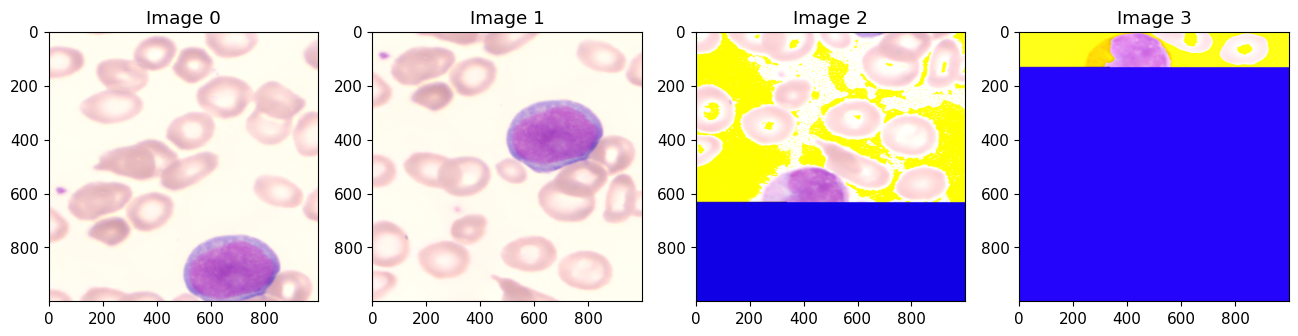

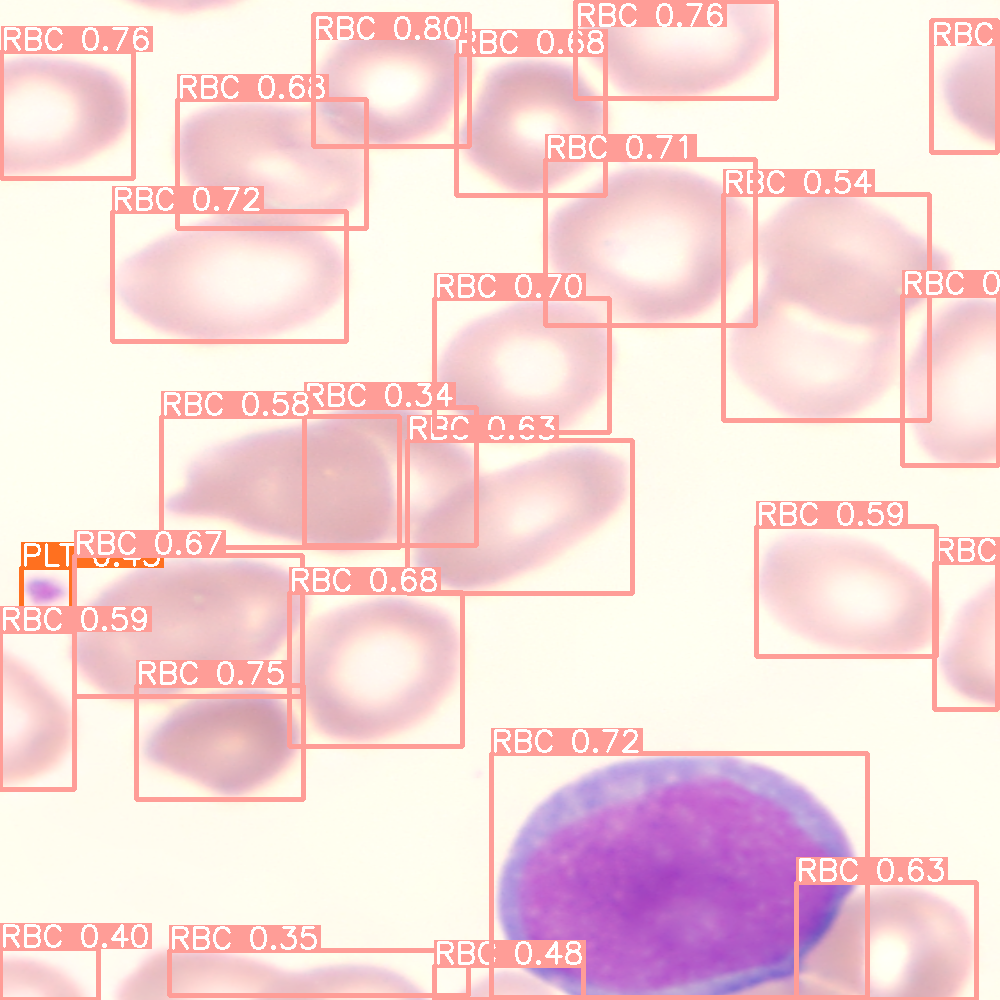

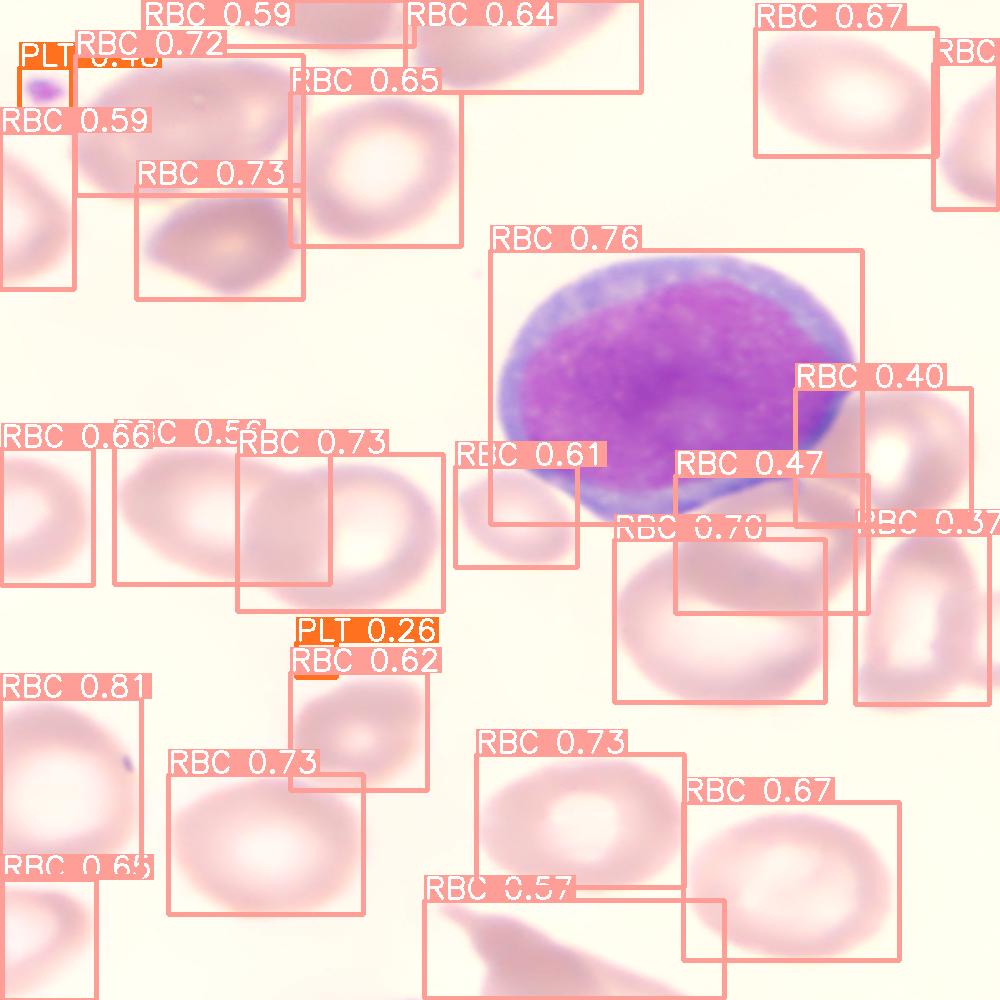

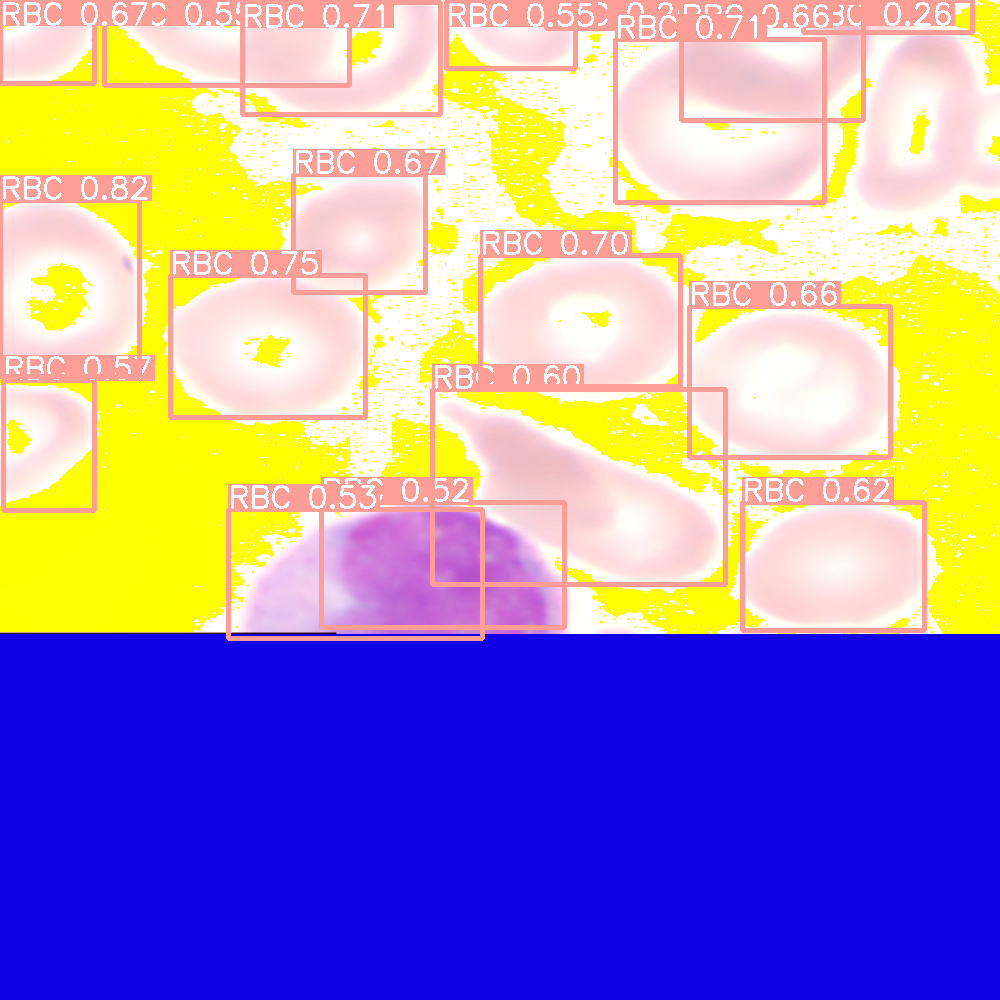

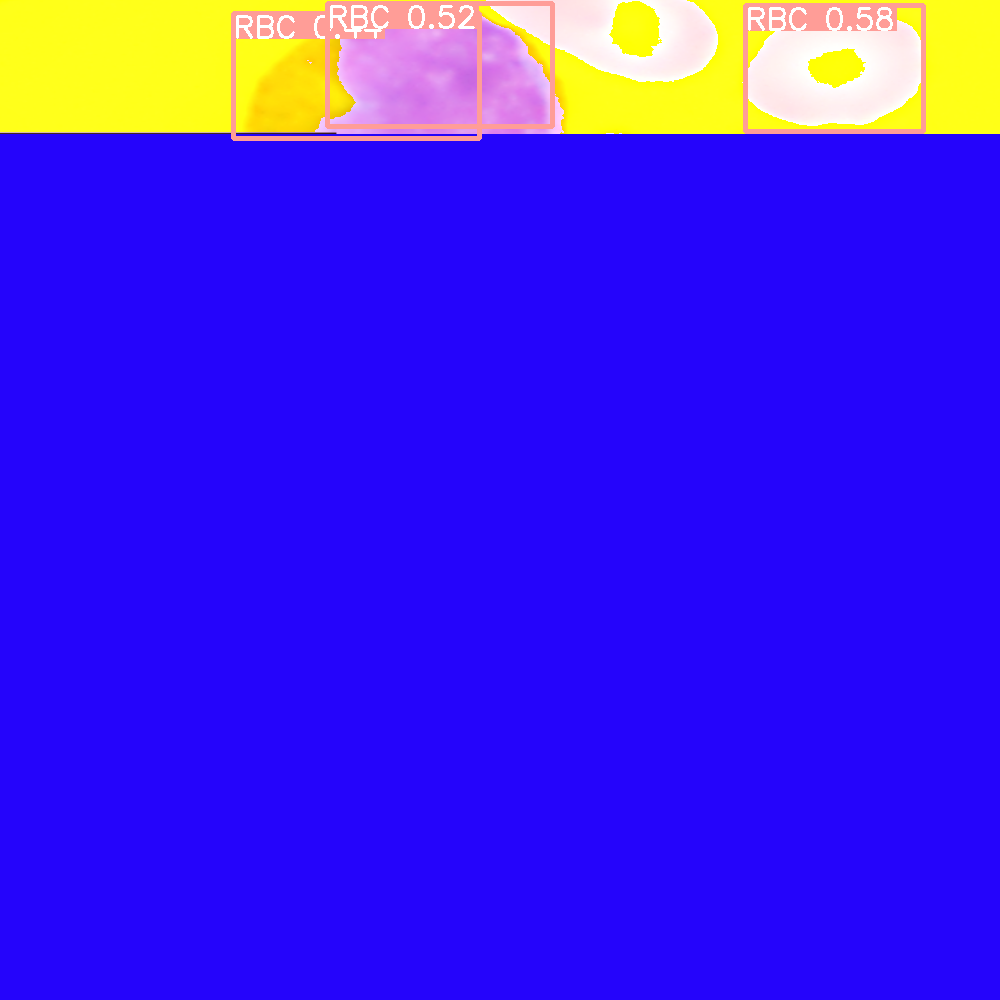

In [37]:
from torchvision.transforms import transforms
split_size = 1000
model_name = 'yolo'
img = img_data_all[0]
step_size = split_size // 2

# Split images
split_images, _, _ = split_image_and_boxes(img, split_size=split_size, step_size=step_size)

mean = img.mean((1,2))
std = img.std((1,2))

print(f'Running inference on {len(split_images)} splits')
all_outputs = []
# Run inference on the batch of splits in groups of batch_size
batch_size = 4
for i in range(0, len(split_images), batch_size):
    print(f'Running inference on batch {i+1}/{len(split_images)}')
    with torch.no_grad():
        if model_name == 'rcnn':
            batch_outputs = model(tuple(split_images[i:i+batch_size]))  # Model takes a tuple of images
        elif model_name == 'yolo':
            # split images to numpy
            print(f'max value: {split_images[i].max()}')
            print(f'min value: {split_images[i].min()}')
            red_imgs = [make_red(img) for img in split_images[i:i+batch_size]]
            model_input = [img.permute(1, 2, 0).numpy()*255 for img in red_imgs]
            # model_input = torch.stack(split_images[i:i+batch_size])*255
            if i == 0:
                for img in model_input:
                    print(f'img shape: {img.shape}')
            # print(f'max value: {model_input.shape}')
            # run inference
            batch_outputs = model(model_input)
            if i == 32:
                        # plot image batch
                        fig, ax = plt.subplots(1, len(model_input), figsize=(16, 8))
                        for j, img in enumerate(model_input):
                            ax[j].imshow(img.astype(np.uint8))
                            ax[j].set_title(f'Image {j}')
                        plt.show()
                        batch_outputs.show()
            batch_outputs = yolo_to_rcnn(batch_outputs, remove_rbc=True)
        if i == 32:
            break

In [ ]:
from torchvision.transforms import transforms

img = img_data_all[0]
mean = img.mean((1,2))
std = img.std((1,2))
print(f'mean: {mean}')
print(f'std: {std}')
tonormalize = split_images[0]
normalize = transforms.Normalize(mean=mean, std=std)
normalize2 = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
min_vals = torch.min(img.view(3, -1), dim=1)[0]  # find the min value for each channel
min_vals = min_vals.view(3, 1, 1)  # reshape for broadcasting
tonormalize = img - min_vals
max_vals = torch.max(img.view(3, -1), dim=1)[0]  # find the min value for each channel
max_vals = max_vals.view(3, 1, 1)  # reshape for broadcasting
tonormalize = tonormalize / max_vals
tonormalize = tonormalize*255
tonormalize = tonormalize.to(dtype=torch.uint8)
plt.imshow(tonormalize.permute(1,2,0).numpy())
plt.imshow((img).permute(1,2,0).numpy())
# plt.imshow(normalized2.permute(1, 2, 0))
plt.show()
print(tonormalize.max())


In [ ]:
min_vals = torch.min(img.view(3, -1), dim=1)[0]  # find the min value for each channel
min_vals = min_vals.view(3, 1, 1)  # reshape for broadcasting
img = img - min_vals  #

In [39]:
for i in range(1, 8, 3):
    print(i)

1
4
7


In [97]:
import cv2
im = cv2.imread('../image_stitching/stich_3.png')


grayscale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Perform thresholding
# You can adjust the threshold value (127 here) as needed
_, thresholded = cv2.threshold(grayscale, 20, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Further noise removal (small white spots)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations = 2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(im,markers)
im[markers == -1] = [0,255,0]

# Initialize a binary mask with zeros (all black)
mask = np.zeros_like(im[:,:,0], dtype=np.uint8)

# Loop over the unique marker values (skipping 0, which is the background)
for marker in np.unique(markers):
    if marker == 0:
        continue

    # Create a binary mask for the current marker
    cell_mask = np.zeros_like(im[:,:,0], dtype=np.uint8)
    cell_mask[markers == marker] = 255

    # Combine this mask with the overall mask using a bitwise OR operation
    mask = cv2.bitwise_or(mask, cell_mask)

# assert mask.shape == im.shape, "Mismatch in shape between mask and image"

# Ensure mask is uint8 and binary
mask = mask.astype(np.uint8)
mask[mask != 0] = 255

# Initialize result image filled with zeros (all black)
highlighted_img = np.zeros_like(im)

print(im[:,:,i].shape)  # should give: (height, width)
print(mask.shape)       # should give: (height, width)

# Apply the mask to each color channel separately
for i in range(3):  # Assuming a 3-channel color image
    highlighted_img[:,:,i] = cv2.bitwise_and(im[:,:,i], mask)


# Overlay the binary mask on the original image

output = np.where(markers == -1, 0, 255).astype('uint8')


# find contours in the watershed output
contours, _ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# array to hold bounding box coordinates
bounding_boxes = []

for contour in contours:
    print(contour.shape)
    # get coordinates of bounding box
    (x, y, w, h) = cv2.boundingRect(contour)
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)  # green rectangle


    bounding_boxes.append([x, y, x+w, y+h])

# Save the result
cv2.imshow('image', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

(3101, 3608)
(3101, 3608)
(22, 1, 2)


In [ ]:
# Load the image
image = cv2.imread('path_to_your_image.jpg', cv2.IMREAD_GRAYSCALE)

